goal: train 10 machine learning predictors: one predictor for each function from the ten protein function categories ("DNA, RNA and nucleotide metabolism", "tail", "head and packaging", "other", "lysis", "connector", "transcription regulation", "moron, auxiliary metabolic gene and host takeover", "unknown function", "integration and excision") 

predictor input: protein features; output: labels (0/1) representing whether the protein serves the specific function

dataset: 360,413 seqs in total - 60% for training, 20% for validation, 20% for testing
-use clustering results to avoid spliting protein seqs in the same cluster (maybe use GroupShuffleSplit from sklearn)

features: 1711-dim

dataset:  
2,318,538 seqs in the original dataset  
927,040 seqs after dropping pcat "unknown_no_hit"  
360,413 unique seqs after dropping duplicated seqs  

In [1]:
import pandas as pd

# data preparation

In [17]:
def add_label(features, ids):
    features["label"] = features["id"].isin(ids["name"]).astype(int)
    features = features.drop(columns=["md5"])
    return features

In [2]:
features = pd.read_parquet("../dataset/protein_features_unique.pa")
tail_ids = pd.read_csv("../dataset/pcat/tail.csv")

In [18]:
features_tail = add_label(features, tail_ids)

In [19]:
features_tail["label"].value_counts()

label
0    286131
1     74282
Name: count, dtype: int64

# training script

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, Any
import joblib
import os
import json

In [30]:
def prepare_data(
    df: pd.DataFrame,
    feature_cols: list,
    cluster_mapping: Dict[str, str],
    label_col: str = "label",
    id_col: str = "id",
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Prepare data for training by separating features and labels.

    Args:
        df: DataFrame containing features and labels
        feature_cols: List of feature column names
        cluster_mapping: Dictionary mapping sequence IDs to cluster IDs
        label_col: Name of the label column
        id_col: Name of the ID column

    Returns:
        X: Feature matrix
        y: Label array
        ids: Array of sequence IDs
        groups: Array of cluster IDs for each sequence
    """
    X = df[feature_cols].values
    y = df[label_col].values
    ids = df[id_col].values

    # Get cluster IDs for each sequence
    groups = np.array([cluster_mapping.get(str(id_), "unknown") for id_ in ids])

    return X, y, ids, groups

In [31]:
def split_data(
    X: np.ndarray,
    y: np.ndarray,
    ids: np.ndarray,
    groups: np.ndarray,
    test_size: float = 0.2,
    val_size: float = 0.2,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Split data into train, validation, and test sets while keeping related sequences together.

    Args:
        X: Feature matrix
        y: Label array
        ids: Array of sequence IDs
        groups: Array of cluster IDs for each sequence
        test_size: Proportion of data to use for testing
        val_size: Proportion of data to use for validation
    """
    # First split: separate test set
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_idx, test_idx = next(gss.split(X, y, groups=groups))

    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val = groups[train_val_idx]

    # Second split: separate validation set from training set
    val_size_adjusted = val_size / (
        1 - test_size
    )  # Adjust val_size to account for test set
    gss = GroupShuffleSplit(n_splits=1, test_size=val_size_adjusted, random_state=42)
    train_idx, val_idx = next(
        gss.split(X_train_val, y_train_val, groups=groups_train_val)
    )

    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [24]:
def train_model(
    X_train: np.ndarray, y_train: np.ndarray, model_params: Dict[str, Any] = None
) -> Tuple[Any, StandardScaler]:
    """Train a Random Forest classifier with optional hyperparameters."""
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Set default parameters if none provided
    if model_params is None:
        model_params = {
            "n_estimators": 100,
            "max_depth": None,
            "min_samples_split": 2,
            "min_samples_leaf": 1,
            "random_state": 42,
        }

    # Train model
    model = RandomForestClassifier(**model_params)
    model.fit(X_train_scaled, y_train)

    return model, scaler

In [25]:
def evaluate_model(
    model: Any, scaler: StandardScaler, X: np.ndarray, y: np.ndarray, set_name: str = ""
) -> Dict[str, float]:
    """Evaluate model performance on a dataset."""
    X_scaled = scaler.transform(X)
    y_pred = model.predict(X_scaled)
    y_pred_proba = model.predict_proba(X_scaled)[:, 1]

    metrics = {
        f"{set_name}_accuracy": accuracy_score(y, y_pred),
        f"{set_name}_precision": precision_score(y, y_pred),
        f"{set_name}_recall": recall_score(y, y_pred),
        f"{set_name}_f1": f1_score(y, y_pred),
        f"{set_name}_roc_auc": roc_auc_score(y, y_pred_proba),
    }

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {set_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return metrics

In [26]:
def save_model(
    model: Any, scaler: StandardScaler, feature_cols: list, function_name: str
):
    """Save the trained model and scaler."""
    # Create models directory if it doesn't exist
    os.makedirs("../models", exist_ok=True)

    # Create a dictionary containing all necessary components
    model_data = {"model": model, "scaler": scaler, "feature_cols": feature_cols}

    # Save the model data
    joblib.dump(model_data, f"../models/{function_name}_predictor.joblib")

In [33]:
def train_function_predictor(df: pd.DataFrame, function_name: str):
    """Main training pipeline for a specific protein function."""
    # Load cluster mapping
    with open("../dataset/protein_cluster_mapping.json", "r") as f:
        cluster_mapping = json.load(f)

    # Get feature columns (excluding 'id' and 'label')
    feature_cols = [col for col in df.columns if col not in ["id", "label"]]

    # Prepare data
    X, y, ids, groups = prepare_data(df, feature_cols, cluster_mapping)

    # Split data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, ids, groups)

    # Train model
    model, scaler = train_model(X_train, y_train)

    # Evaluate model on all sets
    train_metrics = evaluate_model(model, scaler, X_train, y_train, "train")
    val_metrics = evaluate_model(model, scaler, X_val, y_val, "val")
    test_metrics = evaluate_model(model, scaler, X_test, y_test, "test")

    # Print metrics
    print(f"\nTraining Metrics for {function_name}:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")

    print(f"\nValidation Metrics for {function_name}:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")

    print(f"\nTest Metrics for {function_name}:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Save model
    save_model(model, scaler, feature_cols, function_name)

# execution

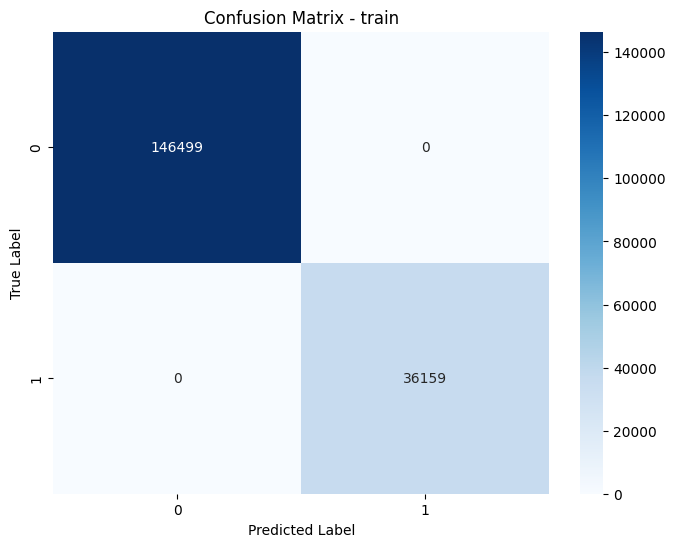

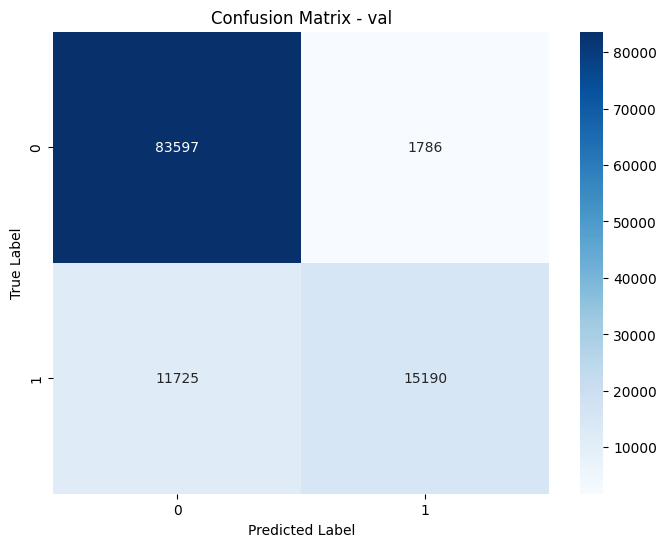

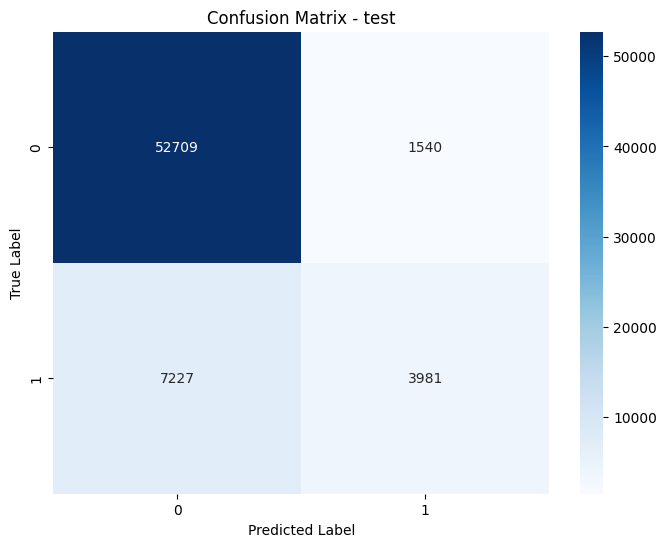


Training Metrics for tail:
train_accuracy: 1.0000
train_precision: 1.0000
train_recall: 1.0000
train_f1: 1.0000
train_roc_auc: 1.0000

Validation Metrics for tail:
val_accuracy: 0.8797
val_precision: 0.8948
val_recall: 0.5644
val_f1: 0.6922
val_roc_auc: 0.9100

Test Metrics for tail:
test_accuracy: 0.8661
test_precision: 0.7211
test_recall: 0.3552
test_f1: 0.4759
test_roc_auc: 0.8332


In [34]:
# Train the predictor for the "tail" function
train_function_predictor(features_tail, "tail")